In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
from sklearn import metrics
from skimage.feature import hog

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

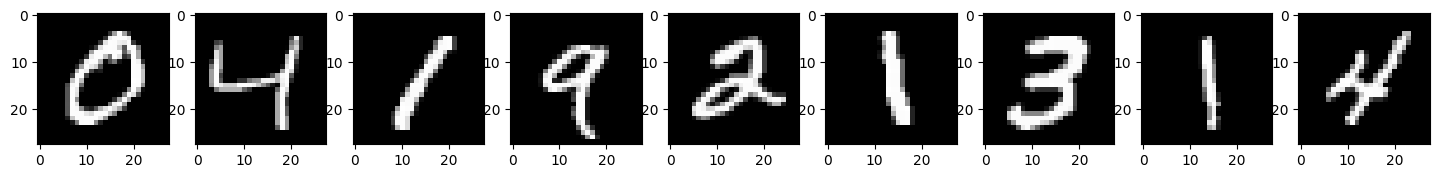

In [ ]:
plt.figure(figsize=(20, 2))
for i in range(1, 10):
    ax = plt.subplot(1, 10, i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

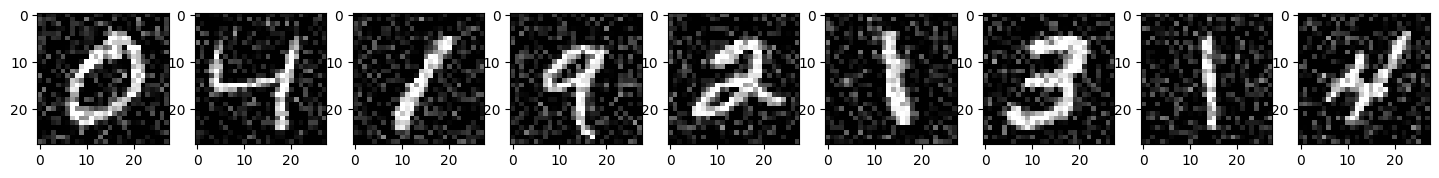

In [ ]:
#Displaying images with noise
plt.figure(figsize=(20, 2))
for i in range(1, 10):
    ax = plt.subplot(1, 10, i)
    plt.imshow(x_train_noisy[i], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
# Extract HOG features
def extract_HOG_features(data):
    num_samples = data.shape[0]
    hog_features = []
    for i in range(num_samples):
        img = data[i]
        feature = hog(img, orientations=4, pixels_per_cell=(3, 3), cells_per_block=(3, 3), block_norm="L2")
        hog_features.append(feature)
    return np.array(hog_features)

In [ ]:
train_features = extract_HOG_features(x_train_noisy)
test_features = extract_HOG_features(x_test_noisy)

In [ ]:
train_features[0].shape

(1764,)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=train_features[0].shape),
  tf.keras.layers.Dense(1024, activation='relu'),
  # tf.keras.layers.Dropout(0),
  # tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(512, activation='relu'),
  # tf.keras.layers.Dropout(0),
  # tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(10, activation = 'softmax')
])

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1764)              0         
                                                                 
 dense (Dense)               (None, 1024)              1807360   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 2,337,290
Trainable params: 2,337,290
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reduceLearningRate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9999, patience=1, min_lr=0.0001)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

# Train model with .fit function
history = model.fit(
    train_features,
    y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=500,
    shuffle = True,
    callbacks=[reduceLearningRate]
)
# model.save(r'/content/drive/MyDrive/Machine Learning/ANN_MNIST/Model/HOG_noise_best.h5')

Epoch 1/100


In [ ]:
predictions = model.predict(test_features)
actual = y_test
print(metrics.accuracy_score(actual, np.argmax(predictions, axis = 1)))

313/313 [==============================] - 1s 2ms/step
0.1009


In [ ]:
print(metrics.classification_report(actual, np.argmax(predictions, axis = 1), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.10      1.00      0.18      1009

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


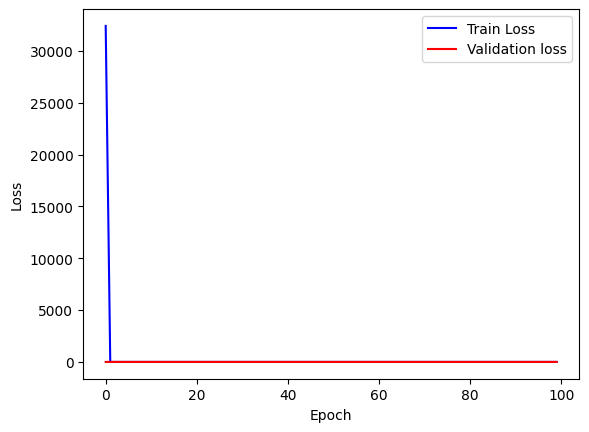

In [ ]:
plt.plot(history.history["loss"], 'b', label="Train Loss")
plt.plot(history.history["val_loss"], 'r', label="Validation loss")
# plt.axis([0, 25, 0, 0.5])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.style.use('default')

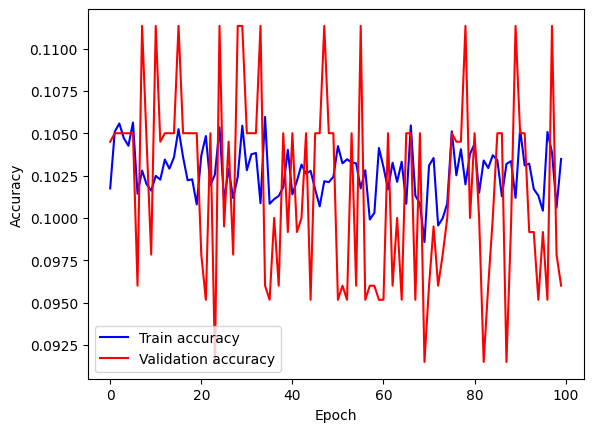

In [ ]:
plt.plot(history.history["accuracy"], 'b', label="Train accuracy")
plt.plot(history.history["val_accuracy"], 'r', label="Validation accuracy")
# plt.axis([0, 25, 0.9, 1])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.style.use('default')

<Axes: xlabel='Predict', ylabel='Actual'>

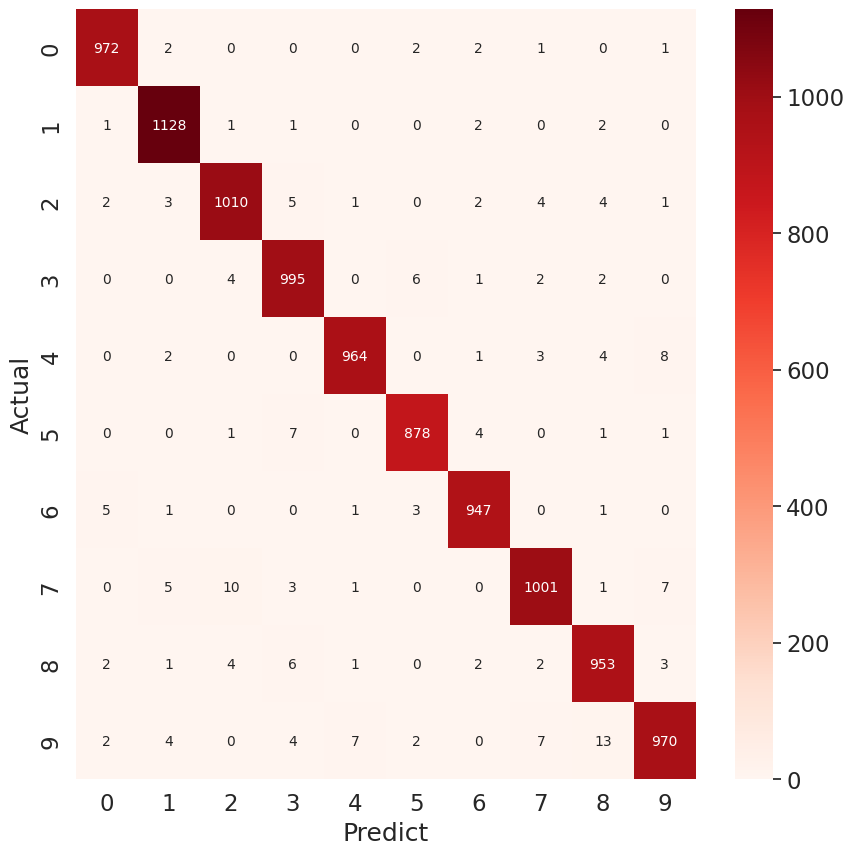

In [ ]:
matrix = metrics.confusion_matrix(
    actual,
    np.argmax(predictions, axis = 1)
)
# Plot confusion matrix with matplotlib
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

DataFrameMatrix = pd.DataFrame(matrix, columns=np.unique(labels), index = np.unique(labels))
DataFrameMatrix.index.name = 'Actual'
DataFrameMatrix.columns.name = 'Predict'
plt.figure(figsize = (10,10))
sn.set(font_scale=1.5)
sn.heatmap(DataFrameMatrix, cmap="Reds", annot=True, annot_kws={"size": 10}, fmt="d")